In [24]:
import os
import time
import json
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.primitives import hashes, serialization
from cryptography.hazmat.primitives.asymmetric import rsa, padding
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC
from cryptography.hazmat.backends import default_backend
from cryptography.exceptions import InvalidSignature
import base64
import matplotlib.pyplot as plt

# AES Key Generate, Save, Load

In [25]:
def generate_aes_key(key_size=128):
    if key_size == 128:
        return os.urandom(16)
    elif key_size == 256:
        return os.urandom(32)
    else:
        raise ValueError("AES key size must be 128 or 256 bits")

In [26]:
def save_key_to_file(key, filename):
    with open(filename, 'wb') as f:
        f.write(base64.b64encode(key))


In [27]:
def load_key_from_file(filename):
    with open(filename, 'rb') as f:
        return base64.b64decode(f.read())

# RSA Key Generate, Save, Load

In [28]:
def generate_rsa_keys(key_size=2048):
    private_key = rsa.generate_private_key(
        public_exponent=65537,
        key_size=key_size,
        backend=default_backend()
    )
    public_key = private_key.public_key()
    return private_key, public_key

In [29]:
def save_rsa_keys(private_key, public_key, priv_file="rsa_private.pem", pub_file="rsa_public.pem"):
    # Save private key
    with open(priv_file, "wb") as f:
        f.write(private_key.private_bytes(
            encoding=serialization.Encoding.PEM,
            format=serialization.PrivateFormat.PKCS8,
            encryption_algorithm=serialization.NoEncryption()
        ))

    # Save public key
    with open(pub_file, "wb") as f:
        f.write(public_key.public_bytes(
            encoding=serialization.Encoding.PEM,
            format=serialization.PublicFormat.SubjectPublicKeyInfo
        ))

In [30]:
def load_rsa_keys(priv_file="rsa_private.pem", pub_file="rsa_public.pem"):
    with open(priv_file, "rb") as f:
        private_key = serialization.load_pem_private_key(
            f.read(),
            password=None,
            backend=default_backend()
        )
    
    with open(pub_file, "rb") as f:
        public_key = serialization.load_pem_public_key(
            f.read(),
            backend=default_backend()
        )
    
    return private_key, public_key

# AES Encrypt & Decrypt

In [31]:
def aes_encrypt(data, key, mode='ECB'):
    # Generate IV for CFB mode
    if mode == 'CFB':
        iv = os.urandom(16)
    else:
        iv = b'\x00' * 16  # ECB doesn't use IV, but we need to pass something
    
    # Create cipher
    if mode == 'ECB':
        cipher = Cipher(algorithms.AES(key), modes.ECB(), backend=default_backend())
    elif mode == 'CFB':
        cipher = Cipher(algorithms.AES(key), modes.CFB(iv), backend=default_backend())
    else:
        raise ValueError("Unsupported mode")
    
    # Encrypt
    encryptor = cipher.encryptor()
    
    # Pad data if necessary (AES requires block size of 16 bytes)
    if len(data) % 16 != 0:
        padding_length = 16 - (len(data) % 16)
        data += b'\x00' * padding_length
    
    encrypted_data = encryptor.update(data) + encryptor.finalize()
    
    if mode == 'CFB':
        return iv + encrypted_data
    return encrypted_data


In [32]:

def aes_decrypt(encrypted_data, key, mode='ECB'):
    """Decrypt data using AES with specified mode"""
    if mode == 'CFB':
        iv = encrypted_data[:16]
        encrypted_data = encrypted_data[16:]
        cipher = Cipher(algorithms.AES(key), modes.CFB(iv), backend=default_backend())
    elif mode == 'ECB':
        cipher = Cipher(algorithms.AES(key), modes.ECB(), backend=default_backend())
    else:
        raise ValueError("Unsupported mode")
    
    decryptor = cipher.decryptor()
    decrypted_data = decryptor.update(encrypted_data) + decryptor.finalize()
    
    # Remove padding
    decrypted_data = decrypted_data.rstrip(b'\x00')
    
    return decrypted_data

In [33]:
def aes_encrypt_file(input_file, output_file, key_size=128, mode='ECB'):
    """Encrypt file using AES"""
    start_time = time.time()
    
    # Generate or load key
    key_file = f"aes_{key_size}_{mode}.key"
    if not os.path.exists(key_file):
        key = generate_aes_key(key_size)
        save_key_to_file(key, key_file)
    else:
        key = load_key_from_file(key_file)
    
    # Read input file
    with open(input_file, 'rb') as f:
        data = f.read()
    
    # Encrypt
    encrypted_data = aes_encrypt(data, key, mode)
    
    # Write encrypted data to output file
    with open(output_file, 'wb') as f:
        f.write(encrypted_data)
    
    end_time = time.time()
    return end_time - start_time

In [34]:
def aes_decrypt_file(input_file, output_file, key_size=128, mode='ECB'):
    """Decrypt file using AES"""
    start_time = time.time()
    
    # Load key
    key_file = f"aes_{key_size}_{mode}.key"
    key = load_key_from_file(key_file)
    
    # Read encrypted file
    with open(input_file, 'rb') as f:
        encrypted_data = f.read()
    
    # Decrypt
    decrypted_data = aes_decrypt(encrypted_data, key, mode)
    
    # Write decrypted data to output file
    with open(output_file, 'wb') as f:
        f.write(decrypted_data)
    
    end_time = time.time()
    
    # Display decrypted content
    try:
        print("Decrypted content:", decrypted_data.decode('utf-8'))
    except:
        print("Decrypted content (binary):", decrypted_data)
    
    return end_time - start_time

# RSA Encrypt & Decrypt

In [35]:
def rsa_encrypt(data, public_key):
    """Encrypt data using RSA"""
    # RSA can only encrypt small amounts of data, so we'll encrypt a symmetric key
    # For demonstration, we'll encrypt the data directly (works for small data)
    encrypted = public_key.encrypt(
        data,
        padding.OAEP(
            mgf=padding.MGF1(algorithm=hashes.SHA256()),
            algorithm=hashes.SHA256(),
            label=None
        )
    )
    return encrypted

In [36]:
def rsa_decrypt(encrypted_data, private_key):
    """Decrypt data using RSA"""
    decrypted = private_key.decrypt(
        encrypted_data,
        padding.OAEP(
            mgf=padding.MGF1(algorithm=hashes.SHA256()),
            algorithm=hashes.SHA256(),
            label=None
        )
    )
    return decrypted

In [37]:
def rsa_encrypt_file(input_file, output_file):
    """Encrypt file using RSA"""
    start_time = time.time()
    
    # Load RSA keys
    private_key, public_key = load_rsa_keys()
    
    # Read input file
    with open(input_file, 'rb') as f:
        data = f.read()
    
    # Encrypt (for large files, we'd encrypt a symmetric key instead)
    encrypted_data = rsa_encrypt(data, public_key)
    
    # Write encrypted data to output file
    with open(output_file, 'wb') as f:
        f.write(encrypted_data)
    
    end_time = time.time()
    return end_time - start_time

In [38]:

def rsa_decrypt_file(input_file, output_file):
    """Decrypt file using RSA"""
    start_time = time.time()
    
    # Load RSA keys
    private_key, public_key = load_rsa_keys()
    
    # Read encrypted file
    with open(input_file, 'rb') as f:
        encrypted_data = f.read()
    
    # Decrypt
    decrypted_data = rsa_decrypt(encrypted_data, private_key)
    
    # Write decrypted data to output file
    with open(output_file, 'wb') as f:
        f.write(decrypted_data)
    
    end_time = time.time()
    
    # Display decrypted content
    try:
        print("Decrypted content:", decrypted_data.decode('utf-8'))
    except:
        print("Decrypted content (binary):", decrypted_data)
    
    return end_time - start_time


# RSA Signature

In [39]:
def rsa_sign_file(input_file, signature_file):
    """Generate RSA signature for a file"""
    start_time = time.time()
    
    # Load RSA keys
    private_key, public_key = load_rsa_keys()
    
    # Read file to sign
    with open(input_file, 'rb') as f:
        data = f.read()
    
    # Generate signature
    signature = private_key.sign(
        data,
        padding.PSS(
            mgf=padding.MGF1(hashes.SHA256()),
            salt_length=padding.PSS.MAX_LENGTH
        ),
        hashes.SHA256()
    )
    
    # Save signature to file
    with open(signature_file, 'wb') as f:
        f.write(signature)
    
    end_time = time.time()
    return end_time - start_time

In [40]:
def rsa_verify_signature(input_file, signature_file):
    """Verify RSA signature"""
    start_time = time.time()
    
    # Load RSA keys
    private_key, public_key = load_rsa_keys()
    
    # Read original file
    with open(input_file, 'rb') as f:
        data = f.read()
    
    # Read signature
    with open(signature_file, 'rb') as f:
        signature = f.read()
    
    # Verify signature
    try:
        public_key.verify(
            signature,
            data,
            padding.PSS(
                mgf=padding.MGF1(hashes.SHA256()),
                salt_length=padding.PSS.MAX_LENGTH
            ),
            hashes.SHA256()
        )
        print("Signature is VALID")
        result = True
    except InvalidSignature:
        print("Signature is INVALID")
        result = False
    
    end_time = time.time()
    return end_time - start_time, result

# SHA-256 hashing

In [41]:
def sha256_hash_file(input_file):
    """Generate SHA-256 hash of a file"""
    start_time = time.time()
    
    # Read file
    with open(input_file, 'rb') as f:
        data = f.read()
    
    # Calculate hash
    digest = hashes.Hash(hashes.SHA256(), backend=default_backend())
    digest.update(data)
    hash_result = digest.finalize()
    
    # Display hash
    print(f"SHA-256 Hash: {hash_result.hex()}")
    
    end_time = time.time()
    return end_time - start_time


In [42]:
def measure_aes_timing():
    """Measure AES execution time for different key sizes"""
    print("Measuring AES timing...")
    
    # Create test file
    test_data = b"This is a test file for timing measurement." * 100  # ~4KB
    with open("test_timing.bin", "wb") as f:
        f.write(test_data)
    
    key_sizes = [128, 256]
    modes = ['ECB', 'CFB']
    results = {}
    
    for key_size in key_sizes:
        results[key_size] = {}
        for mode in modes:
            encrypt_time = aes_encrypt_file("test_timing.bin", "test_encrypted.bin", key_size, mode)
            decrypt_time = aes_decrypt_file("test_encrypted.bin", "test_decrypted.bin", key_size, mode)
            results[key_size][mode] = {
                'encrypt': encrypt_time,
                'decrypt': decrypt_time
            }
    
    # Clean up
    for file in ["test_timing.bin", "test_encrypted.bin", "test_decrypted.bin"]:
        if os.path.exists(file):
            os.remove(file)
    
    return results

In [43]:
def measure_rsa_timing():
    """Measure RSA execution time for different key sizes"""
    print("Measuring RSA timing...")
    
    # Create test file with small data (RSA can only encrypt small amounts)
    test_data = b"Test data for RSA timing"
    with open("test_rsa.bin", "wb") as f:
        f.write(test_data)
    
    key_sizes = [1024, 2048, 3072, 4096]  # Different RSA key sizes
    results = {}
    
    for key_size in key_sizes:
        print(f"Testing RSA with {key_size}-bit key...")
        
        # Generate new keys for this size
        private_key, public_key = generate_rsa_keys(key_size)
        save_rsa_keys(private_key, public_key, f"rsa_private_{key_size}.pem", f"rsa_public_{key_size}.pem")
        
        # Time encryption
        start_time = time.time()
        encrypted = rsa_encrypt(test_data, public_key)
        encrypt_time = time.time() - start_time
        
        # Time decryption
        start_time = time.time()
        decrypted = rsa_decrypt(encrypted, private_key)
        decrypt_time = time.time() - start_time
        
        results[key_size] = {
            'encrypt': encrypt_time,
            'decrypt': decrypt_time
        }
    
    # Clean up
    if os.path.exists("test_rsa.bin"):
        os.remove("test_rsa.bin")
    
    return results

In [44]:
def plot_timing_results(aes_results, rsa_results):
    """Plot timing results"""
    # Plot AES results
    plt.figure(figsize=(12, 5))
    
    # AES subplot
    plt.subplot(1, 2, 1)
    key_sizes = list(aes_results.keys())
    encrypt_times_ecb = [aes_results[size]['ECB']['encrypt'] for size in key_sizes]
    decrypt_times_ecb = [aes_results[size]['ECB']['decrypt'] for size in key_sizes]
    encrypt_times_cfb = [aes_results[size]['CFB']['encrypt'] for size in key_sizes]
    decrypt_times_cfb = [aes_results[size]['CFB']['decrypt'] for size in key_sizes]
    
    width = 0.2
    x = range(len(key_sizes))
    
    plt.bar([i - width for i in x], encrypt_times_ecb, width, label='AES-ECB Encrypt')
    plt.bar(x, decrypt_times_ecb, width, label='AES-ECB Decrypt')
    plt.bar([i + width for i in x], encrypt_times_cfb, width, label='AES-CFB Encrypt')
    plt.bar([i + 2*width for i in x], decrypt_times_cfb, width, label='AES-CFB Decrypt')
    
    plt.xlabel('Key Size (bits)')
    plt.ylabel('Time (seconds)')
    plt.title('AES Encryption/Decryption Timing')
    plt.xticks(x, [f'{size}' for size in key_sizes])
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # RSA subplot
    plt.subplot(1, 2, 2)
    rsa_key_sizes = list(rsa_results.keys())
    rsa_encrypt_times = [rsa_results[size]['encrypt'] for size in rsa_key_sizes]
    rsa_decrypt_times = [rsa_results[size]['decrypt'] for size in rsa_key_sizes]
    
    plt.plot(rsa_key_sizes, rsa_encrypt_times, 'o-', label='RSA Encrypt')
    plt.plot(rsa_key_sizes, rsa_decrypt_times, 's-', label='RSA Decrypt')
    
    plt.xlabel('Key Size (bits)')
    plt.ylabel('Time (seconds)')
    plt.title('RSA Encryption/Decryption Timing')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('timing_results.png')
    print("Timing plot saved as 'timing_results.png'")
    plt.show()

In [45]:
def initialize_keys():
    """Initialize all required keys if they don't exist"""
    # Generate RSA keys if they don't exist
    if not os.path.exists("rsa_private.pem") or not os.path.exists("rsa_public.pem"):
        print("Generating RSA keys...")
        private_key, public_key = generate_rsa_keys(2048)
        save_rsa_keys(private_key, public_key)
        print("RSA keys generated and saved.")
    
    # Note: AES keys will be generated on-demand during encryption

# SImple UI


          CRYPTOGRAPHY PROGRAM
1. AES Encryption/Decryption
2. RSA Encryption/Decryption
3. RSA Signature
4. SHA-256 Hashing
5. Measure Execution Time
6. Exit



--- AES Operations ---
1. Encrypt file
2. Decrypt file
3. Back to main menu
Decrypted content: I am Yasin Bashar. I am a student.
Decryption completed in 0.0010 seconds

          CRYPTOGRAPHY PROGRAM
1. AES Encryption/Decryption
2. RSA Encryption/Decryption
3. RSA Signature
4. SHA-256 Hashing
5. Measure Execution Time
6. Exit

--- RSA Signature Operations ---
1. Generate signature
2. Verify signature
3. Back to main menu
Signature generated in 0.0894 seconds

          CRYPTOGRAPHY PROGRAM
1. AES Encryption/Decryption
2. RSA Encryption/Decryption
3. RSA Signature
4. SHA-256 Hashing
5. Measure Execution Time
6. Exit

--- RSA Signature Operations ---
1. Generate signature
2. Verify signature
3. Back to main menu
Signature is VALID
Verification completed in 0.1063 seconds

          CRYPTOGRAPHY PROGRAM
1. AES Encryption/Decryption
2. RSA Encryption/Decryption
3. RSA Signature
4. SHA-256 Hashing
5. Measure Execution Time
6. Exit

--- Timing Measurements ---
Measuring execution times...


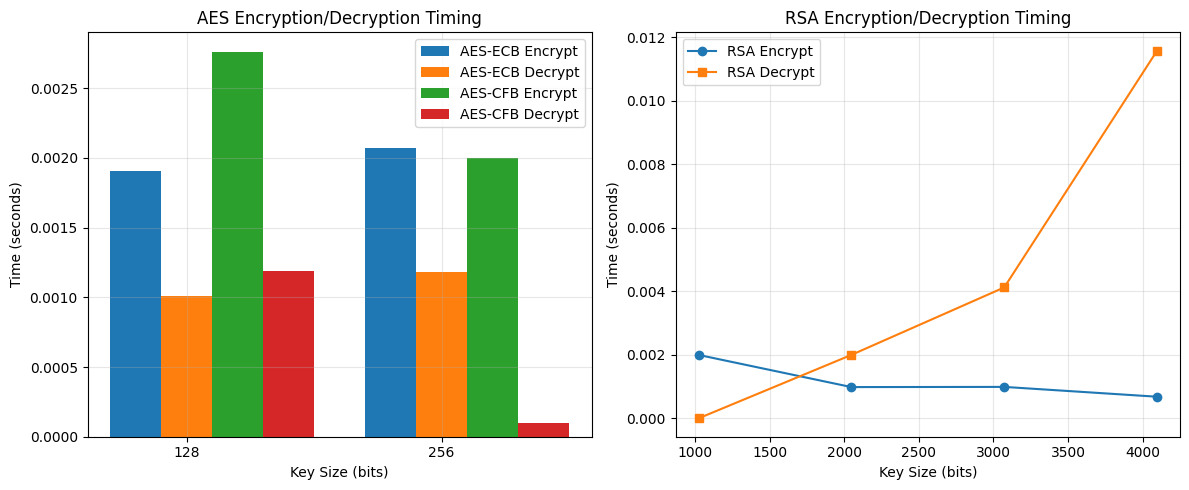


          CRYPTOGRAPHY PROGRAM
1. AES Encryption/Decryption
2. RSA Encryption/Decryption
3. RSA Signature
4. SHA-256 Hashing
5. Measure Execution Time
6. Exit

--- RSA Operations ---
1. Encrypt file
2. Decrypt file
3. Back to main menu
Encryption completed in 0.0938 seconds

          CRYPTOGRAPHY PROGRAM
1. AES Encryption/Decryption
2. RSA Encryption/Decryption
3. RSA Signature
4. SHA-256 Hashing
5. Measure Execution Time
6. Exit

--- RSA Operations ---
1. Encrypt file
2. Decrypt file
3. Back to main menu
Decrypted content: I am Yasin Bashar. I am a student.
Decryption completed in 0.1136 seconds

          CRYPTOGRAPHY PROGRAM
1. AES Encryption/Decryption
2. RSA Encryption/Decryption
3. RSA Signature
4. SHA-256 Hashing
5. Measure Execution Time
6. Exit


In [ ]:
def main_menu():
    """Display main menu and handle user input"""
    initialize_keys()
    
    while True:
        print("\n" + "="*50)
        print("          CRYPTOGRAPHY PROGRAM")
        print("="*50)
        print("1. AES Encryption/Decryption")
        print("2. RSA Encryption/Decryption")  
        print("3. RSA Signature")
        print("4. SHA-256 Hashing")
        print("5. Measure Execution Time")
        print("6. Exit")
        print("="*50)
        
        choice = input("Enter your choice (1-6): ").strip()
        
        if choice == '1':
            aes_menu()
        elif choice == '2':
            rsa_menu()
        elif choice == '3':
            rsa_signature_menu()
        elif choice == '4':
            hashing_menu()
        elif choice == '5':
            timing_menu()
        elif choice == '6':
            print("Goodbye!")
            break
        else:
            print("Invalid choice. Please try again.")

def aes_menu():
    """AES operations menu"""
    print("\n--- AES Operations ---")
    print("1. Encrypt file")
    print("2. Decrypt file")
    print("3. Back to main menu")
    
    choice = input("Enter your choice (1-3): ").strip()
    
    if choice == '1':
        input_file = input("Enter input file name: ")
        output_file = input("Enter output file name: ")
        key_size = int(input("Enter key size (128 or 256): "))
        mode = input("Enter mode (ECB or CFB): ").upper()
        
        if key_size not in [128, 256] or mode not in ['ECB', 'CFB']:
            print("Invalid parameters!")
            return
        
        time_taken = aes_encrypt_file(input_file, output_file, key_size, mode)
        print(f"Encryption completed in {time_taken:.4f} seconds")
        
    elif choice == '2':
        input_file = input("Enter encrypted file name: ")
        output_file = input("Enter output file name: ")
        key_size = int(input("Enter key size (128 or 256): "))
        mode = input("Enter mode (ECB or CFB): ").upper()
        
        if key_size not in [128, 256] or mode not in ['ECB', 'CFB']:
            print("Invalid parameters!")
            return
        
        time_taken = aes_decrypt_file(input_file, output_file, key_size, mode)
        print(f"Decryption completed in {time_taken:.4f} seconds")
    
    elif choice == '3':
        return
    else:
        print("Invalid choice!")

def rsa_menu():
    """RSA operations menu"""
    print("\n--- RSA Operations ---")
    print("1. Encrypt file")
    print("2. Decrypt file")
    print("3. Back to main menu")
    
    choice = input("Enter your choice (1-3): ").strip()
    
    if choice == '1':
        input_file = input("Enter input file name: ")
        output_file = input("Enter output file name: ")
        
        time_taken = rsa_encrypt_file(input_file, output_file)
        print(f"Encryption completed in {time_taken:.4f} seconds")
        
    elif choice == '2':
        input_file = input("Enter encrypted file name: ")
        output_file = input("Enter output file name: ")
        
        time_taken = rsa_decrypt_file(input_file, output_file)
        print(f"Decryption completed in {time_taken:.4f} seconds")
    
    elif choice == '3':
        return
    else:
        print("Invalid choice!")

def rsa_signature_menu():
    """RSA signature operations menu"""
    print("\n--- RSA Signature Operations ---")
    print("1. Generate signature")
    print("2. Verify signature")
    print("3. Back to main menu")
    
    choice = input("Enter your choice (1-3): ").strip()
    
    if choice == '1':
        input_file = input("Enter file to sign: ")
        signature_file = input("Enter signature file name: ")
        
        time_taken = rsa_sign_file(input_file, signature_file)
        print(f"Signature generated in {time_taken:.4f} seconds")
        
    elif choice == '2':
        input_file = input("Enter original file: ")
        signature_file = input("Enter signature file: ")
        
        time_taken, is_valid = rsa_verify_signature(input_file, signature_file)
        print(f"Verification completed in {time_taken:.4f} seconds")
    
    elif choice == '3':
        return
    else:
        print("Invalid choice!")

def hashing_menu():
    """Hashing operations menu"""
    print("\n--- SHA-256 Hashing ---")
    input_file = input("Enter file to hash: ")
    
    time_taken = sha256_hash_file(input_file)
    print(f"Hashing completed in {time_taken:.4f} seconds")

def timing_menu():
    """Timing measurement menu"""
    print("\n--- Timing Measurements ---")
    print("Measuring execution times...")
    
    aes_results = measure_aes_timing()
    rsa_results = measure_rsa_timing()
    
    print("\nAES Timing Results:")
    for key_size, modes in aes_results.items():
        for mode, times in modes.items():
            print(f"  AES-{key_size}-{mode}: Encrypt={times['encrypt']:.6f}s, Decrypt={times['decrypt']:.6f}s")
    
    print("\nRSA Timing Results:")
    for key_size, times in rsa_results.items():
        print(f"  RSA-{key_size}: Encrypt={times['encrypt']:.6f}s, Decrypt={times['decrypt']:.6f}s")
    
    # Plot results
    plot_timing_results(aes_results, rsa_results)

if __name__ == "__main__":
    main_menu()